In [1]:
# Cell 1 — imports and settings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import random

# plotting defaults
plt.rcParams.update({'figure.figsize': (10,6), 'font.size': 12})
sns.set(style='whitegrid')

RNG = 42
np.random.seed(RNG)
random.seed(RNG)


In [2]:
# Cell 2 — create mock core tables: patients, admissions, icustays
n_patients = 1500
n_admissions = n_patients  # 1 admission per patient for simplicity
n_icustays = n_patients

# Patients
patients = pd.DataFrame({
    'subject_id': np.arange(1, n_patients+1),
    'gender': np.random.choice(['M','F'], size=n_patients, p=[0.55,0.45]),
    'anchor_age': np.random.randint(18, 90, size=n_patients),
    'anchor_year': np.random.choice(np.arange(2010,2024), size=n_patients)
})

# Admissions
start = pd.Timestamp('2015-01-01')
admittimes = [start + pd.to_timedelta(int(x), unit='d') for x in np.random.randint(0, 365*8, size=n_admissions)]
dischtimes = [t + pd.to_timedelta(np.random.randint(1, 20), unit='d') for t in admittimes]
admissions = pd.DataFrame({
    'hadm_id': np.arange(1000, 1000+n_admissions),
    'subject_id': patients['subject_id'],
    'admittime': pd.to_datetime(admittimes),
    'dischtime': pd.to_datetime(dischtimes),
    'admission_type': np.random.choice(['EMERGENCY','ELECTIVE','URGENT'], size=n_admissions, p=[0.6,0.25,0.15]),
    'insurance': np.random.choice(['Medicare','Private','Medicaid','Self-pay'], size=n_admissions, p=[0.35,0.45,0.1,0.1])
})

# ICU stays
intimes = [t + pd.to_timedelta(np.random.randint(0,2), unit='d') for t in admittimes]
outtimes = [t + pd.to_timedelta(np.random.randint(1, 10), unit='d') for t in intimes]
icustays = pd.DataFrame({
    'icustay_id': np.arange(2000, 2000+n_icustays),
    'subject_id': patients['subject_id'],
    'hadm_id': admissions['hadm_id'],
    'intime': pd.to_datetime(intimes),
    'outtime': pd.to_datetime(outtimes)
})
icustays['los'] = (icustays['outtime'] - icustays['intime']).dt.total_seconds()/(24*3600)


In [3]:
# Cell 3 — derive merged df and flags
df = icustays.merge(admissions, on=['subject_id','hadm_id']).merge(patients, on='subject_id')
# Simulate in-hospital death (rare)
df['in_hospital_death'] = np.random.choice([0,1], size=len(df), p=[0.93, 0.07])
df['admit_year'] = df['admittime'].dt.year
df['admit_month'] = df['admittime'].dt.to_period('M').astype(str)
df.head()


,icustay_id,subject_id,hadm_id,intime,outtime,los,admittime,dischtime,admission_type,insurance,gender,anchor_age,anchor_year,in_hospital_death,admit_year,admit_month
0,2000,1,1000,2016-02-21,2016-02-23,2.0,2016-02-21,2016-02-25,EMERGENCY,Private,M,65,2015,0,2016,2016-02
1,2001,2,1001,2020-01-23,2020-01-28,5.0,2020-01-23,2020-01-30,URGENT,Private,F,83,2015,0,2020,2020-01
2,2002,3,1002,2021-06-13,2021-06-19,6.0,2021-06-13,2021-06-15,URGENT,Medicaid,F,87,2011,0,2021,2021-06
3,2003,4,1003,2022-05-20,2022-05-25,5.0,2022-05-20,2022-05-26,EMERGENCY,Private,F,45,2019,0,2022,2022-05
4,2004,5,1004,2019-09-14,2019-09-17,3.0,2019-09-14,2019-10-01,URGENT,Private,M,43,2015,0,2019,2019-09


In [4]:
# Cell 4 — create mock diagnoses_icd (top 20 ICD codes random)
icd_codes = [f"I{100+i}" for i in range(1,31)]
diag_rows = []
for i, hadm in enumerate(admissions['hadm_id']):
    n = np.random.poisson(1.5) + 1
    chosen = list(np.random.choice(icd_codes, size=n, replace=False))
    for code in chosen:
        diag_rows.append({'subject_id': admissions.loc[i,'subject_id'], 'hadm_id': hadm, 'icd_code': code})

diagnoses = pd.DataFrame(diag_rows)
diagnoses['icd_code'] = diagnoses['icd_code'].astype(str)
diagnoses.head()


,subject_id,hadm_id,icd_code
0,1,1000,I112
1,1,1000,I103
2,1,1000,I119
3,2,1001,I118
4,2,1001,I116


In [5]:
# Cell 5 — mock chartevents (vitals) for a few icustays (not full huge table)
# We'll sample 50 icustays and simulate time-series vitals (HR, RR, Temp, SpO2)
sample_icus = np.random.choice(icustays['icustay_id'], size=50, replace=False)
chart_rows = []
vital_types = {'220045': 'Heart Rate', '220210': 'Resp Rate', '223761': 'Temperature', '220277': 'SpO2'}
for icu in sample_icus:
    base_time = icustays.loc[icustays['icustay_id']==icu,'intime'].values[0]
    # 48 time points, every 30 minutes
    times = [pd.to_datetime(base_time) + timedelta(minutes=30*i) for i in range(48)]
    for t in times:
        hr = np.random.normal(80, 12)
        rr = np.random.normal(18, 3)
        temp = np.random.normal(36.8, 0.6)
        spo2 = np.random.normal(96, 2)
        chart_rows.append({'icustay_id': icu, 'charttime': t, 'itemid': 220045, 'valuenum': max(30, hr)})
        chart_rows.append({'icustay_id': icu, 'charttime': t, 'itemid': 220210, 'valuenum': max(5, rr)})
        chart_rows.append({'icustay_id': icu, 'charttime': t, 'itemid': 223761, 'valuenum': temp})
        chart_rows.append({'icustay_id': icu, 'charttime': t, 'itemid': 220277, 'valuenum': min(100, spo2)})
chartevents = pd.DataFrame(chart_rows)
# map itemid to label
item_map = pd.DataFrame([{'itemid':int(k),'label':v} for k,v in vital_types.items()])
chartevents = chartevents.merge(item_map, on='itemid', how='left')
chartevents.head()


,icustay_id,charttime,itemid,valuenum,label
0,3250,2015-12-12 00:00:00,220045,55.136371,Heart Rate
1,3250,2015-12-12 00:00:00,220210,19.265134,Resp Rate
2,3250,2015-12-12 00:00:00,223761,37.444385,Temperature
3,3250,2015-12-12 00:00:00,220277,95.715392,SpO2
4,3250,2015-12-12 00:30:00,220045,71.850618,Heart Rate


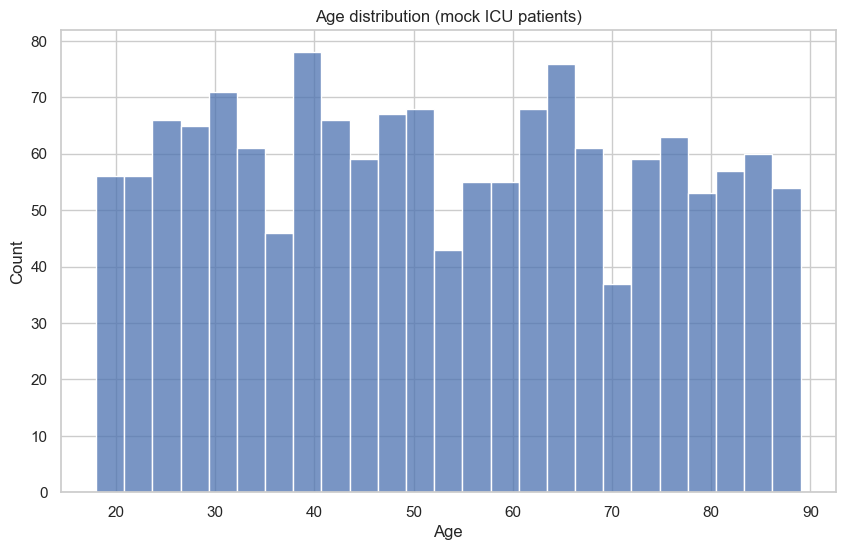

In [7]:
# Cell 7 — Age distribution
plt.figure()
sns.histplot(df['anchor_age'], bins=25, kde=False)
plt.title('Age distribution (mock ICU patients)')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()


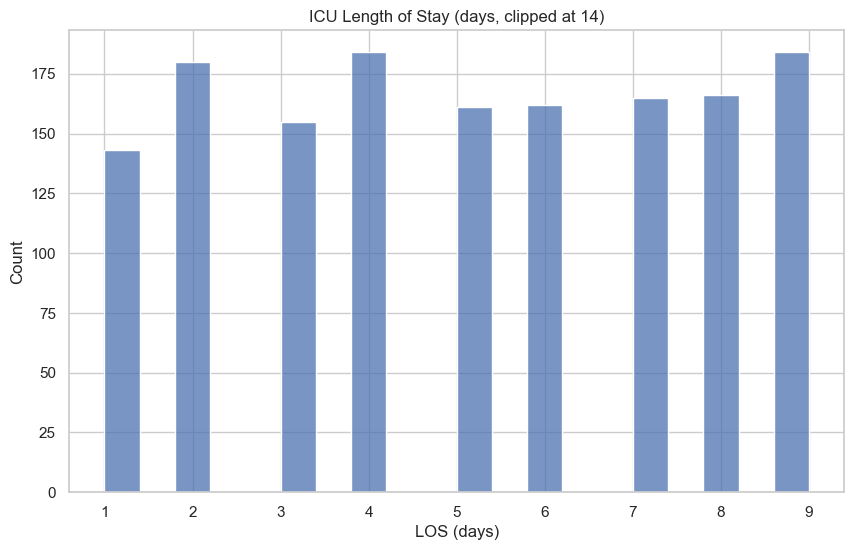

In [8]:
# Cell 8 — LOS distribution (clipped)
plt.figure()
sns.histplot(df['los'].clip(upper=14), bins=20)
plt.title('ICU Length of Stay (days, clipped at 14)')
plt.xlabel('LOS (days)')
plt.show()


Simulated in-hospital mortality: 6.93%


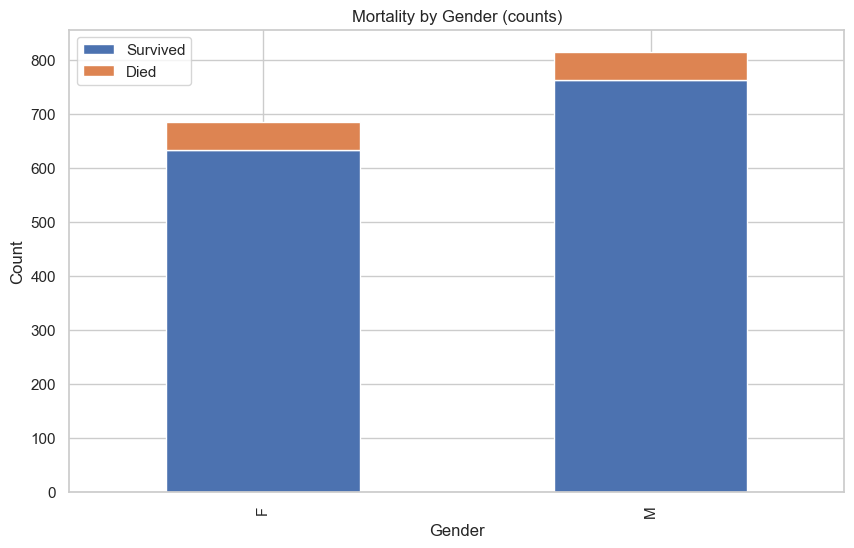

In [9]:
# Cell 9 — Mortality rate and stacked bar by gender
mortality_rate = df['in_hospital_death'].mean()
print(f"Simulated in-hospital mortality: {mortality_rate:.2%}")

# stacked bar: gender vs mortality
ct = df.groupby(['gender','in_hospital_death']).size().unstack(fill_value=0)
ct.plot(kind='bar', stacked=True)
plt.title('Mortality by Gender (counts)')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(['Survived','Died'])
plt.show()


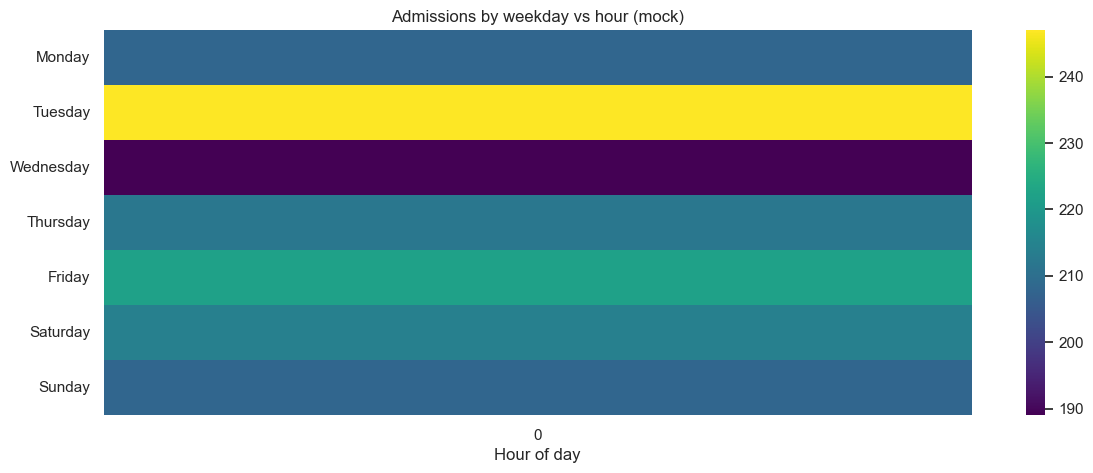

In [10]:
# Cell 10 — Admissions by weekday vs hour heatmap
ad = admissions.copy()
ad['admit_hour'] = ad['admittime'].dt.hour
ad['admit_wday'] = ad['admittime'].dt.day_name()
pivot = ad.pivot_table(index='admit_wday', columns='admit_hour', values='hadm_id', aggfunc='count').reindex(
    ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
)
plt.figure(figsize=(14,5))
sns.heatmap(pivot.fillna(0), cmap='viridis')
plt.title('Admissions by weekday vs hour (mock)')
plt.ylabel('')
plt.xlabel('Hour of day')
plt.show()


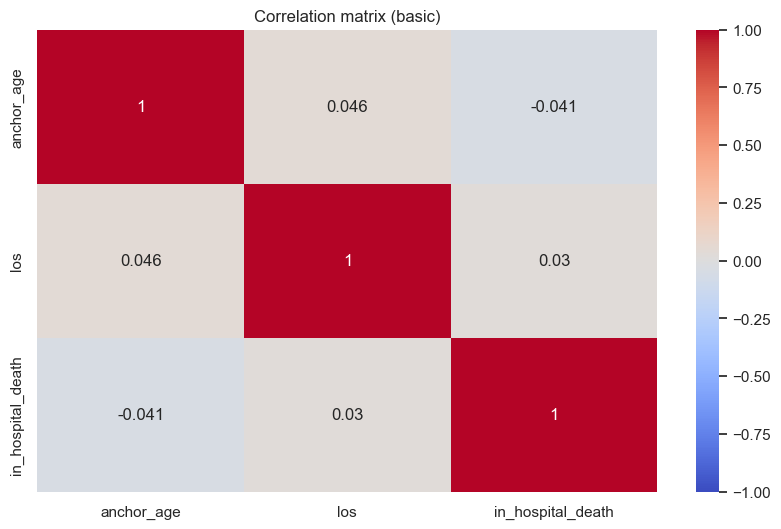

In [11]:
# Cell 11 — Correlation heatmap among numeric features
numeric_cols = ['anchor_age','los','in_hospital_death']
corr = df[numeric_cols].corr()
plt.figure()
sns.heatmap(corr, annot=True, vmin=-1, vmax=1, cmap='coolwarm')
plt.title('Correlation matrix (basic)')
plt.show()


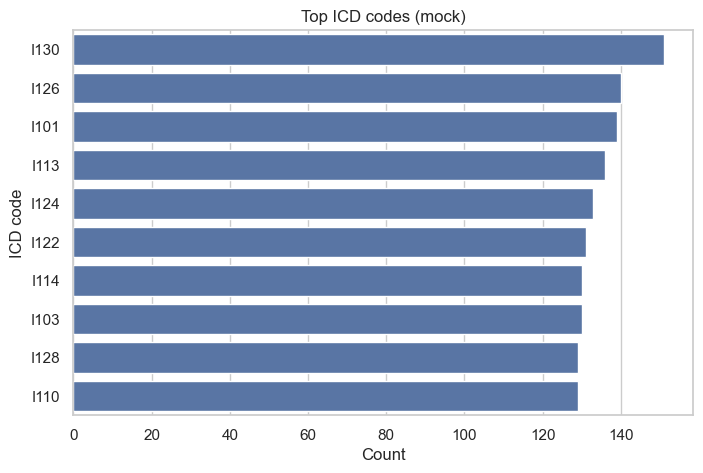

In [12]:
# Cell 12 — Top ICD codes bar chart
top_codes = diagnoses['icd_code'].value_counts().head(10)
plt.figure(figsize=(8,5))
sns.barplot(x=top_codes.values, y=top_codes.index)
plt.title('Top ICD codes (mock)')
plt.xlabel('Count')
plt.ylabel('ICD code')
plt.show()


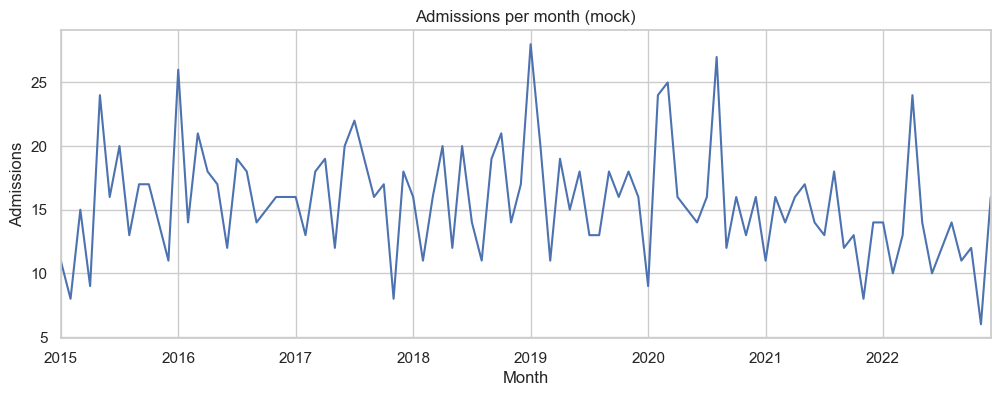

In [13]:
# Cell 13 — Admissions per month (time series)
adm_counts = admissions.groupby(admissions['admittime'].dt.to_period('M')).size().sort_index()
plt.figure(figsize=(12,4))
adm_counts.plot()
plt.title('Admissions per month (mock)')
plt.xlabel('Month')
plt.ylabel('Admissions')
plt.show()


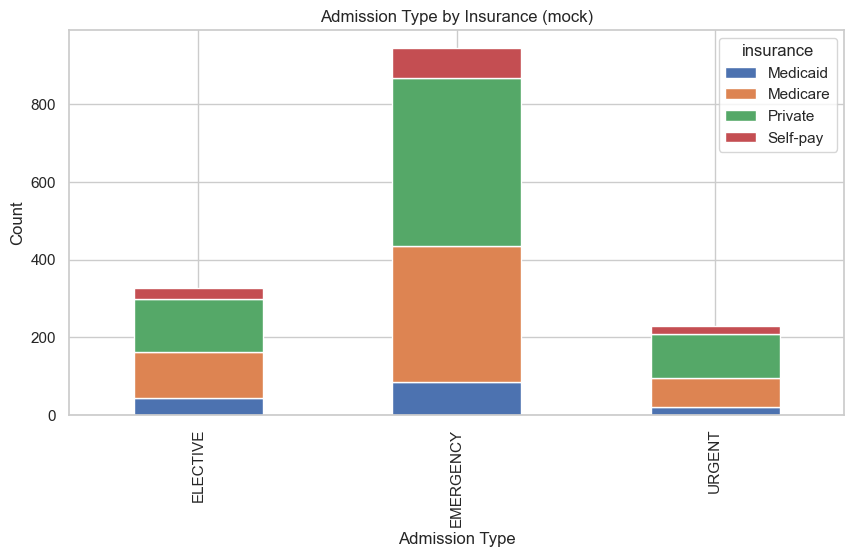

In [14]:
# Cell 14 — Admission type vs insurance (stacked bar)
pt = admissions.groupby(['admission_type','insurance']).size().unstack(fill_value=0)
pt.plot(kind='bar', stacked=True, figsize=(10,5))
plt.title('Admission Type by Insurance (mock)')
plt.xlabel('Admission Type')
plt.ylabel('Count')
plt.show()


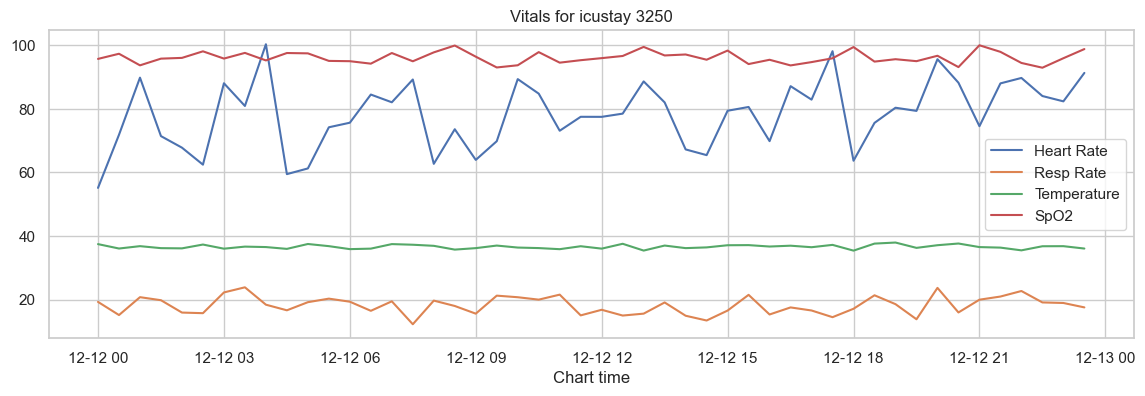

In [15]:
# Cell 15 — Vitals time-series for one icustay (line plots)
sample_icu = chartevents['icustay_id'].unique()[0]
sub = chartevents[chartevents['icustay_id']==sample_icu].copy()
plt.figure(figsize=(14,4))
for label in sub['label'].unique():
    s = sub[sub['label']==label]
    plt.plot(s['charttime'], s['valuenum'], label=label)
plt.title(f'Vitals for icustay {sample_icu}')
plt.xlabel('Chart time')
plt.legend()
plt.show()


/var/folders/67/f7tt4bl53c758trm8cl283tc0000gn/T/ipykernel_5217/1401604663.py:7: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  pv = sub[sub['label'].isin(top_labels)].pivot_table(index=pd.Grouper(freq='30T'), columns='label', values='valuenum', aggfunc='mean')


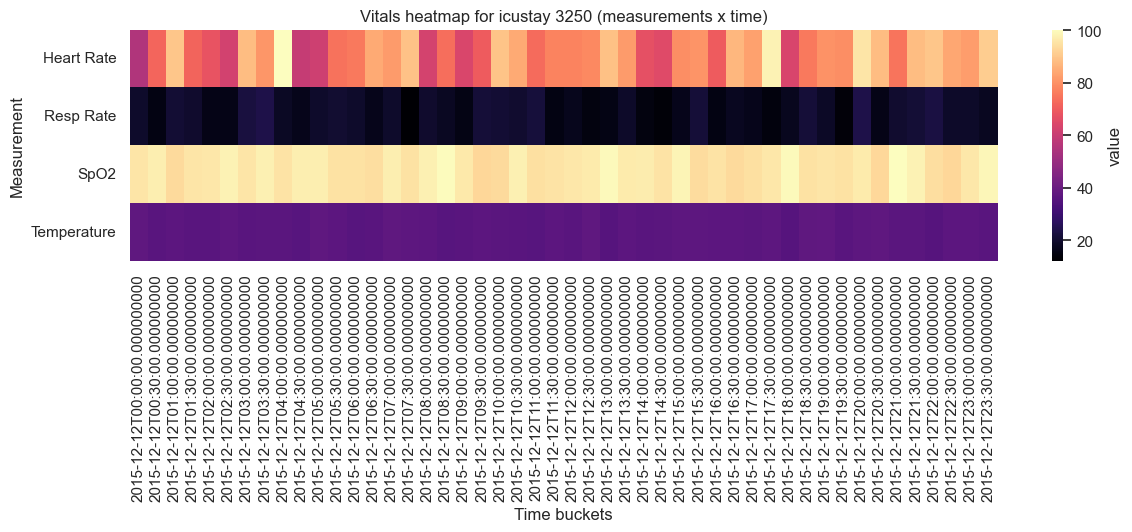

In [16]:
# Cell 16 — Vitals heatmap: pivot (labels x time buckets)
# pick an ICU and resample to 30-min bins
icu_id = chartevents['icustay_id'].unique()[0]
sub = chartevents[chartevents['icustay_id']==icu_id].set_index('charttime')
# keep top 4 labels
top_labels = sub['label'].value_counts().index[:4].tolist()
pv = sub[sub['label'].isin(top_labels)].pivot_table(index=pd.Grouper(freq='30T'), columns='label', values='valuenum', aggfunc='mean')
# transpose so rows=label
pv_t = pv.T
plt.figure(figsize=(14,3))
sns.heatmap(pv_t, cmap='magma', cbar_kws={'label':'value'})
plt.title(f'Vitals heatmap for icustay {icu_id} (measurements x time)')
plt.xlabel('Time buckets')
plt.ylabel('Measurement')
plt.show()


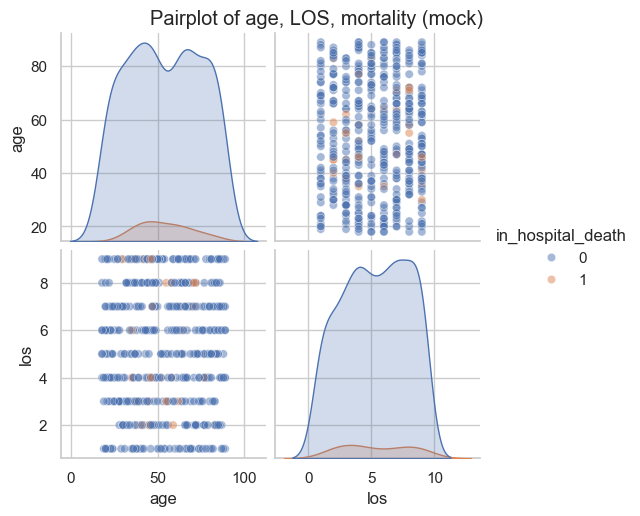

In [19]:
# Cell 19 — Pairplot of small numeric subset (sample 500 rows)
sample = df.sample(min(500, len(df)), random_state=RNG)
sns.pairplot(sample[['anchor_age','los','in_hospital_death']].rename(columns={'anchor_age':'age'}), hue='in_hospital_death', diag_kind='kde', plot_kws={'alpha':0.5})
plt.suptitle('Pairplot of age, LOS, mortality (mock)', y=1.02)
plt.show()
